In [1]:
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt

In [2]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG, EURUSD
import backtesting

import yfinance as yf

c:\users\tomhe\appdata\local\programs\python\python38\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

##### Data

In [3]:
start = '2000-01-01'
interval = '1d'
# symbol = 'EURILS=X'
# symbol = 'EURUSD=X'
symbol = 'USDEUR=X'

data = yf.download(symbol, start=start, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01 00:00:00+00:00,0.83098,0.83724,0.83056,0.83577,0.83577,0
2003-12-02 00:00:00+00:00,0.83605,0.83710,0.82583,0.82720,0.82720,0
2003-12-03 00:00:00+00:00,0.82713,0.82802,0.82440,0.82488,0.82488,0
2003-12-04 00:00:00+00:00,0.82508,0.83029,0.82345,0.82775,0.82775,0
2003-12-05 00:00:00+00:00,0.82795,0.82878,0.82028,0.82055,0.82055,0
...,...,...,...,...,...,...
2023-04-03 00:00:00+01:00,0.92564,0.92684,0.91611,0.92564,0.92564,0
2023-04-04 00:00:00+01:00,0.91640,0.91879,0.91144,0.91640,0.91640,0
2023-04-05 00:00:00+01:00,0.91240,0.91698,0.91164,0.91240,0.91240,0


In [5]:
from modules.tools import pattern_detection
from modules import utils
from modules.utils import bullish_reversal, bearish_reversal


# Cnadlestick Plot

In [6]:
%matplotlib widget

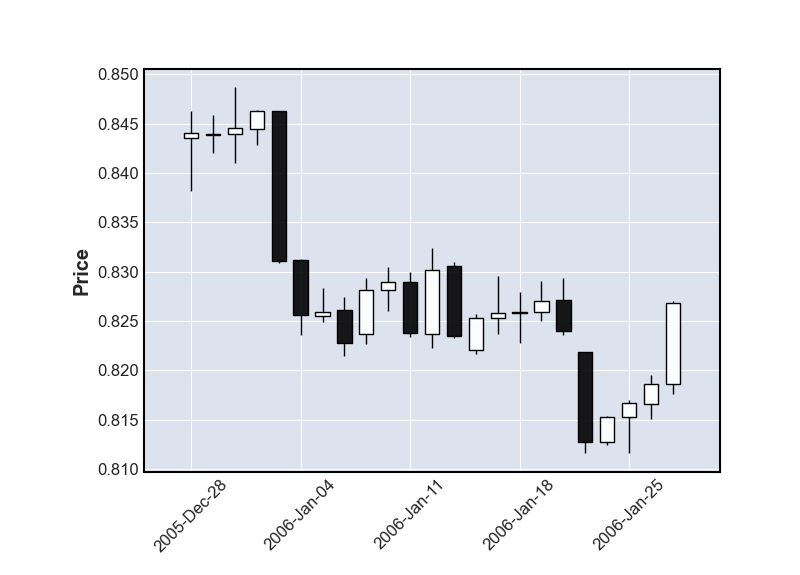

In [7]:
plot_data = data[540:563]

plt.close('all')
mpf.plot(plot_data, type='candlestick')

In [8]:
print(pattern_detection.is_hammer(plot_data, hammer_strength_th=1.2, check_for=3))
print(pattern_detection.is_bullish_engulfing(plot_data, enforce_bear=False))

False
True


Confirmation:
V

Patterns:
1 candle before confirmation
Pattern is_bullish_engulfing found!
Bullish Reversal: True


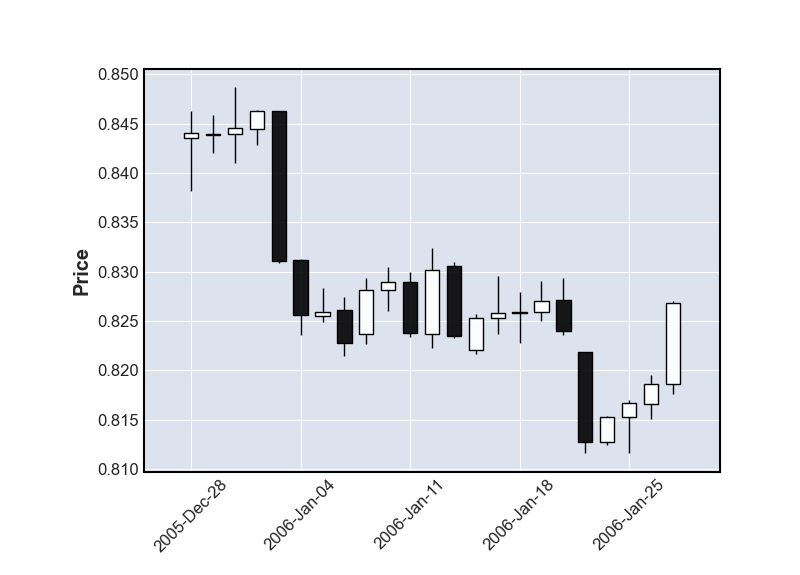

In [9]:

bull_rev_res = bullish_reversal(
    plot_data,
    # bullish_patterns = [is_hammer, is_bullish_engulfing],
    max_bull_without_pattern = 3,
    min_bull_confirmation=1,
    verbose=1
)

print('Bullish Reversal: {}'.format(bull_rev_res))

plt.close('all')
mpf.plot(plot_data, type='candlestick')

# Trend Detectors

## Naive

In [10]:
def is_bull_naive(
    df_data,
    check_for=5,
):
    '''
    Check if all the last <check_for> candles have been bullish.
    '''
    
    if check_for == 0: return True  # nothing to check

    # we go in reverse chronological order, starting with the most recent candlestick
    df_data_rev = df_data.iloc[::-1]
    
    # goes from df_data_rev[0] to df_data[check_for-1] and checks if those candles are bullish
    for i in range(check_for):  
        cur_candle = df_data_rev.iloc[i]
        is_bull = cur_candle['Close'] > cur_candle['Open']
        
        # it's a bearish candlestick!
        if not is_bull:  
            return False
    
    return True



def is_bear_naive(
    df_data,
    check_for=5,
):
    '''
    Check if all the last <check_for> candles have been bearish.
    '''
    
    if check_for == 0: return True  # nothing to check 
    
    # we go in reverse chronological order, starting with the most recent candlestick
    df_data_rev = df_data.iloc[::-1]
    
    # goes from df_data_rev[0] to df_data[check_for-1] and checks if those candles are bullish
    for i in range(check_for):  
        cur_candle = df_data_rev.iloc[i]
        is_bear = cur_candle['Close'] < cur_candle['Open']
        
        # it's a bullish candlestick!
        if not is_bear:  
            return False
    
    return True

## Little Less Naive

But still, pretty naive

In [11]:
def is_bull(
    df_data,
    check_for=5,
):
    '''
    Check if most of the last <check_for> candles have been bullish and that the price has gone up.
    '''
    
    if check_for == 0: return True  # nothing to check 
    
    # first, we check if the overall the price has gone up
    first_open = df_data.iloc[-check_for]['Open']
    last_close = df_data.iloc[-1]['Close']
    
    # if price has gone down, not much of a bull
    if last_close < first_open: return False  
    
    # we go in reverse chronological order, starting with the most recent candlestick
    df_data_rev = df_data.iloc[::-1]
    
    # goes from df_data_rev[0] to df_data[check_for-1] and checks if there are more bears than bulls
    bulls = 0
    for i in range(check_for):  
        cur_candle = df_data_rev.iloc[i]
        bulls += 1 if cur_candle['Close'] > cur_candle['Open'] else -1

    return bulls > 0

def is_bear(
    df_data,
    check_for=5,
):
    '''
    Check if most of the last <check_for> candles have been bearish and that the price has gone down.
    '''
    
    if check_for == 0: return True  # nothing to check 
    
    # first, we check if the overall the price has gone down
    first_open = df_data.iloc[-check_for]['Open']
    last_close = df_data.iloc[-1]['Close']
    
    # if price has gone up, not much of a bear
    if last_close > first_open: return False  
    
    # we go in reverse chronological order, starting with the most recent candlestick
    df_data_rev = df_data.iloc[::-1]
    
    # goes from df_data_rev[0] to df_data[check_for-1] and checks if there are more bears than bulls
    bears = 0
    for i in range(check_for):  
        cur_candle = df_data_rev.iloc[i]
        bears += 1 if cur_candle['Close'] < cur_candle['Open'] else -1
    
    return bears > 0

## Reversal Detection

Pattern Indentifying Functions

In [12]:
eps = 1e-5  # to ensure we don't divide in zero

def is_hammer(
    df_data,
    hammer_strength_th = 1.2,  # required ratio between lower shadow and the rest of the candle
    check_for=3, 
):
    '''
    A hammer isn't necesarily bullish or bearish, therefore a doji can be a legitimate hammer.
    A hammer must come in the context of a bearish trend.
    '''
    
    # confirm the last <check_for> candles that came before the last one are bearish.
    data_check_for_bear = df_data[-check_for-1:-1]
    bear_trend = is_bear(data_check_for_bear, check_for=check_for)
    
    # without a bear trend this isn't a true hammer!
    if not bear_trend: return False
    
    candle = df_data.iloc[-1]
    
    open_data = candle['Open']
    close_data = candle['Close']
    high_data = candle['High']
    low_data = candle['Low']
    
    body = np.abs(open_data - close_data)
    
    body_min = min(open_data, close_data)
    body_max = max(open_data, close_data)
    
    upper_shadow = high_data - body_max
    lower_shadow = body_min - low_data
        
    hammer_strength = lower_shadow / (body + upper_shadow + eps)
    
    return hammer_strength > hammer_strength_th



def is_bullish_engulfing(
    df_data,
    enforce_bear = False,
):
    '''
    Check if the last candle is a bullish engulfing pattern, i.e. if the candle that came before was bearish, and this one is bullish 
    and has a close bigger than the previous high.
    
    Input:
        df_data (pd.DataFrame) - OHLC data
        enforce_bear (boolean) - indicates if we insist on the last one being bearish. If false, we just check for engulfment
    
    Returns:
        is_bull_eng (boolean) - is the last candle in a bullish engulfing pattern
    '''

    curr_candle = df_data.iloc[-1]
    prev_candle = df_data.iloc[-2]
    
    # if we require the previous candle is a bear, and it isn't, return False
    if enforce_bear and prev_candle['Close'] > prev_candle['Open']: return False
        
    # we require the current candle is bullish
    if curr_candle['Close'] < curr_candle['Open']: return False

    # now all that's left is to check if the current close engulfes the previous high
    return curr_candle['Close'] > prev_candle['High'] and curr_candle['Open'] < prev_candle['Close']

In [13]:
def bullish_reversal(
    df_data,
    bullish_patterns = [is_hammer, is_bullish_engulfing],
    max_bull_without_pattern = 3,
    min_bull_confirmation = 1,
    verbose = 0,
):
    '''
    Gets a Pandas DataFrame with OHLC data and returns whether the last few candlesticks indicate a bullish reversal (down to up).
    
    Input:
        df_data (pd.DataFrame) - OHLC data.
        bullish_patterns (list of functions) - a list of functions looking for patterns indicating bullish reversal
        max_bull_without_pattern (int) - maximal number of "confirmation" candles without a pattern indicating a bullish reversal
        min_bull_confirmation (int) - minimal number of bullish "confirmation" candles
        verbose (int) - to print, or not to print
        
    Returns:
        bull (boolean) - A boolean indicator, telling whether there has just now been a bullish reversal.
    '''
    
    # # we go in reverse chronological order, starting with the most recent candlestick
    # df_data_rev = df_data.iloc[::-1]
    
    
    if verbose > 0: print('Confirmation:')
    
    # =============================================================================
    # =========================== CONFIRMATION ====================================
    # =============================================================================
    
    # first we check for confirmation - is the most recent candlestick bullish?
    for i in range(1, min_bull_confirmation+1):
        last_candle = df_data.iloc[-i]
        if last_candle['Close'] < last_candle['Open']: 
            if verbose > 0: print('Most recent candle bearish - quitting')
            return False

    # =============================================================================
    # =========================== CONFIRMATION ====================================
    # =============================================================================
    if verbose > 0:
        print('V\n')
        print('Patterns:')
    # =============================================================================
    # ====================== LOOKING FOR PATTERNS =================================
    # =============================================================================
    '''
    goes from df_data[-2] to df_data[-max_bull-1]
    checks if those candles are bullish or a pattern indicaing a bullish reversal
    '''    
    for i in range(min_bull_confirmation, max_bull_without_pattern + min_bull_confirmation):  
        
        if verbose > 0: print('{} candle before confirmation'.format(i))
        
        '''
        we check if one of the known bullish reversal patterns happens in this spot
        this requires sending some past data, for now, we send all the past data
        '''
        data_check_pattern = df_data[:-i]  # from start to -i (including -i)
        is_bull_rev_pattern = False
        for func in bullish_patterns:
            is_bull_rev_pattern = is_bull_rev_pattern or func(data_check_pattern)
            
            # if we found one, no need to search further
            if is_bull_rev_pattern: 
                if verbose > 0: print('Pattern {} found!'.format(func.__name__))
                return True 
        
        if verbose > 0: print('No pattern')
        
        '''
        if no pattern was found we insist this candle must be bullish
        '''
        cur_candle = df_data.iloc[-i-1]
        is_bull = cur_candle['Close'] - cur_candle['Open'] > 0
        
        
        if not is_bull: 
            if verbose > 0: print("Isn't a bull - return False")
            return False
        if verbose > 0: print('Is bullish - continue'.format(i-1))
    
    # =============================================================================
    # ====================== LOOKING FOR PATTERNS =================================
    # =============================================================================
    
    if verbose > 0: print('No Patterns - Returning False')
    
    '''
    If we reached this point, no pattern was detected on the last <max_bull_without_pattern>, so we return False
    '''
    return False

# Strategy

In [289]:
from scipy.signal import find_peaks

class TrendCapture(Strategy):
    
    # ma_len = 50   # when looking for peaks above the M.A., how many bins the M.A. is calculated on.
    # peak_width = 5  # how many bins wide a peak has to have in order to be recognized  
    
    ma_len = 60   # when looking for peaks above the M.A., how many bins the M.A. is calculated on.
    peak_width = 6  # how many bins wide a peak has to have in order to be recognized
    
    patience = 3  # how many consecutive samples to wait for reversal validation after seeing an indication for a reversal
    entry_price_sleeve_thickness_factor = 0.1  # draw a "price sleeve" around a peak. determines if the price had gone back to around the price after the peak.
    size_randomity = 0.3  # we pick the enter size randomly (0 - no entry, 1 - entire equity). this is the std for the random distribution picking the size
    
    sell_sizes = []
    buy_sizes = []
    
    def init(self):
        price = self.data.Close
        self.ma = self.I(SMA, price, self.ma_len)
        self.starting_cash = self.equity        
        
        
    def next(self):
        sig = self.data.Close
        peaks_loc, peaks_info = find_peaks(sig, width=self.peak_width)
        dips_loc, dips_info = find_peaks(-sig, width=self.peak_width)

        # IS UP-TREND?
        latest_peak = None
        peaks_abv_ma = 0
        for i in range(len(peaks_loc)):
            cur_peak = peaks_loc[-i-1]  # starts from -1, goes to -len(peaks_loc)

            # is this peak above the MA?
            if self.ma[cur_peak] < sig[cur_peak]:
                peaks_abv_ma += 1

                # the last two peaks have been above the MA & the more recent peak is higher
                if peaks_abv_ma == 2 and sig[latest_peak] > sig[cur_peak]:
                    break
                # keep looking for a pair of consecutive peaks that fit the aboce criteria
                else:
                    peaks_abv_ma = 1
                    latest_peak = cur_peak
            else:
                peaks_abv_ma = 0

        # IS DOWN-TREND?
        latest_dip = None
        dips_blw_ma = 0
        for i in range(len(dips_loc)):
            cur_dip = dips_loc[-i-1]  # starts from -1, goes to -len(peaks_loc)

            # is this dip below the MA?
            if self.ma[cur_dip] > sig[cur_dip]:
                dips_blw_ma += 1

                # the last two dips have been below the MA & the more recent dip is lower
                if dips_blw_ma == 2 and sig[latest_dip] < sig[cur_dip]:
                    break
                # keep looking for consecutive peaks that fit the aboce criteria
                else:
                    dips_blw_ma = 1
                    latest_dip = cur_dip
            else:
                dips_blw_ma = 0


        '''
        certainly: latest_dip != latest_peak (latest dip must be below MA, peak must be above,
        cant happen together).

        Therefore the signal is in one of the following two states:
        1. Down Trend: latest_dip > latest_peak
        1. Up Trend:   latest_dip < latest_peak
        
        HOWEVER, one of them, or both, can be None
        '''
        if latest_dip is None and latest_peak is not None:
            up_trend = True
            down_trend = False
        elif latest_dip is not None and latest_peak is None:
            down_trend = True
            up_trend = False
        elif latest_dip is None and latest_peak is None:
            return None
        else:
            down_trend = latest_dip > latest_peak
            up_trend = not down_trend

        entry_price_loc = latest_dip if down_trend else latest_peak

        # determine valid entry prices
        entry_price = sig[entry_price_loc]
        entry_price_sleeve_thickness = self.entry_price_sleeve_thickness_factor * entry_price

        should_enter = sig[-1] > entry_price - entry_price_sleeve_thickness and sig[-1] < entry_price + entry_price_sleeve_thickness

        if should_enter and down_trend:
            
            final_decision = bearish_reversal(
                self.data.df,
                # bull_rev_patterns = [is_hammer, is_bullish_engulfing],
                max_bear_without_pattern = self.patience,
            )
            
            if final_decision: 
                eq_pct = self.equity / self.starting_cash  # equity in percentage
                size = np.clip(np.random.normal(loc=eq_pct/100, scale=0.3), 1e-2, 1)
                self.sell_sizes.append(size)
                self.sell(size=size)
            # if final_decision: self.sell()
        elif should_enter and up_trend:
            
            final_decision = bullish_reversal(
                self.data.df,
                # bull_rev_patterns = [is_hammer, is_bullish_engulfing],
                max_bull_without_pattern = self.patience,
            )
            if final_decision:
                # eq_pct = self.equity / self.starting_cash  # equity in percentage
                eq_pct = 50  # entry size from equity in percentage
                size = np.clip(np.random.normal(loc=eq_pct/100, scale=self.size_randomity), 1e-2, 1)
                self.buy_sizes.append(size)
                self.buy(size=size)    
            # if final_decision: self.buy()
        # else:
            # keep


# The Playground

### Symbols Bank

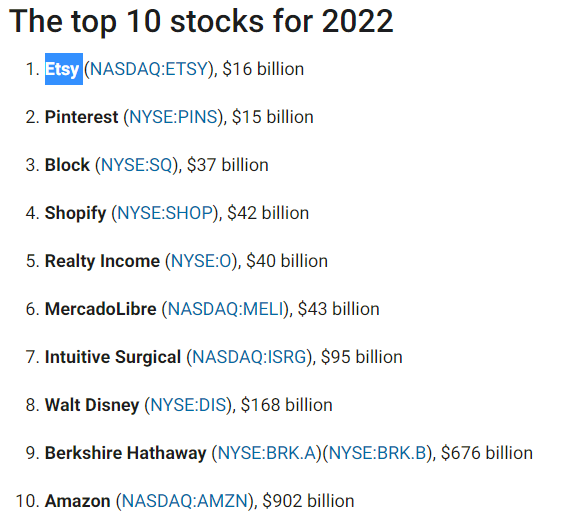

In [252]:
symbol = 'SPY'  # SPYDER S&P 500
symbol = 'AAPL'  # APPLE
symbol = 'MSFT'  # MICROSOFT
symbol = 'TSLA'
symbol = 'NVDA'

# Country ETFs
country_etfs = {
    'usa': 'SPY',  # SPYDER S&P 500 - USA
    'israel': 'ISRA',  # VanEck Israel ETF
    
}

# ForEx
symbol = 'ILS=X'  # how many ILS is A USD
symbol = 'EUR=X'  # how many Euro is A USD

### Wins & Loses

**Wins**</br>
start = '2018-01-01'
interval = '1d'
symbol = 'SPY'

start = '2010-01-01'
interval = '1d'
symbol = 'AAPL'

start = '2018-01-01'
interval = '1d'
symbol = 'MSFT'

start = '2022-01-01'
interval = '1d'
symbol = 'TSLA'

**Loses**</br>
start = '2010-01-01'
interval = '1d'
symbol = 'MSFT'

start = '2010-01-01'
interval = '1d'
symbol = 'ILS=X'

start = '2010-01-01'
interval = '1d'
symbol = 'EUR=X'

start = '2022-01-01'
interval = '1d'
symbol = 'SPY'

### Data

In [539]:
start = '2015-01-01'
end = '2020-01-01'
interval = '1d'
symbol = 'AAPL'

data = yf.download(symbol, start=start, end=end, interval=interval)

[*********************100%***********************]  1 of 1 completed


##### Run

In [540]:
# num_tests = 10
# mean_return = 0
# from tqdm.notebook import tqdm
# tqdm_iter = tqdm(range(num_tests))
# for i in range(1, num_tests+1):
#     bt = Backtest(data, strategy=TrendCapture, commission=.002,
#                   exclusive_orders=True, trade_on_close=True)
#     stats = bt.run()
#     mean_return += dict(stats)['Return [%]']
#     tqdm_iter.update()
#     tqdm_iter.set_description('Mean Return = {:.2f}%'.format(mean_return/i))
# mean_return /= num_tests

In [541]:
# mean_return

In [542]:
# yearly_mean_return = mean_return/(dict(stats)['Duration'].days/365)
# yearly_mean_return

In [543]:
# TrendCapture.sell_sizes

In [591]:
st = TrendCapture
# st.ma_len = 60
# st.peak_width = 3
# st.patience = 5  # how many consecutive samples to wait for reversal validation after seeing an indication for a reversal
# st.entry_price_sleeve_thickness_factor = 0.2  # draw a "price sleeve" around a peak. determines if the price had gone back to around the price after the peak.
# st.size_randomity = 0.0  # we pick the enter size randomly (0 - no entry, 1 - entire equity). this is the std for the random distribution picking the size


# st.ma_len = 40
# st.peak_width = 1
# st.patience = 3  # how many consecutive samples to wait for reversal validation after seeing an indication for a reversal
# st.entry_price_sleeve_thickness_factor = 0.2  # draw a "price sleeve" around a peak. determines if the price had gone back to around the price after the peak.
# st.size_randomity = 0.0  # we pick the enter size randomly (0 - no entry, 1 - entire equity). this is the std for the random distribution picking the size


# MSFT AAPL
# st.ma_len = 30
# st.peak_width = 3
# st.patience = 1  # how many consecutive samples to wait for reversal validation after seeing an indication for a reversal
# st.entry_price_sleeve_thickness_factor = 0.1  # draw a "price sleeve" around a peak. determines if the price had gone back to around the price after the peak.
# st.size_randomity = 0.0  # we pick the enter size randomly (0 - no entry, 1 - entire equity). this is the std for the random distribution picking the size

# EURO-DOLLAR
st.ma_len = 30
st.peak_width = 3
st.patience = 1  # how many consecutive samples to wait for reversal validation after seeing an indication for a reversal
st.entry_price_sleeve_thickness_factor = 0.2  # draw a "price sleeve" around a peak. determines if the price had gone back to around the price after the peak.
st.size_randomity = 0.0  # we pick the enter size randomly (0 - no entry, 1 - entire equity). this is the std for the random distribution picking the size


bt = Backtest(data, strategy=st, commission=.002,
                  exclusive_orders=True, trade_on_close=False)
stats = bt.run()

In [592]:
# plt.figure(figsize=(15, 5))
# plt.subplot(2, 1, 1)
# plt.plot(st.sell_sizes)

# plt.subplot(2, 1, 2)
# plt.plot(st.buy_sizes)

### Stats

In [593]:
stats

Start                     2015-01-02 00:00...
End                       2019-12-31 00:00...
Duration                   1824 days 00:00:00
Exposure Time [%]                   95.786963
Equity Final [$]                 14618.038182
Equity Peak [$]                  14658.980587
Return [%]                          46.180382
Buy & Hold Return [%]              168.590496
Return (Ann.) [%]                    7.902187
Volatility (Ann.) [%]                9.782985
Sharpe Ratio                         0.807748
Sortino Ratio                        1.262257
Calmar Ratio                         0.497344
Max. Drawdown [%]                  -15.888773
Avg. Drawdown [%]                   -1.662858
Max. Drawdown Duration      657 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                  119
Win Rate [%]                        58.823529
Best Trade [%]                      20.839674
Worst Trade [%]                    -20.468618
Avg. Trade [%]                    

### Plot

In [587]:
bt.plot(show_legend=True)

Row(id='38750', ...)

### Optimize

In [519]:
# best_stats, heatmap = bt.optimize(th_high_IBS=list(np.linspace(0.7, 0.99, 5)), th_low_IBS=list(np.linspace(0.3, 0.01, 5)), return_heatmap=True)

In [523]:
%%time
best_stats, heatmap = bt.optimize(
    entry_price_sleeve_thickness_factor = [0.05, 0.1, 0.15, 0.3, 0.5,  0.7, 0.9],
    patience = list(np.arange(1, 10, 1)),
    ma_len=list(np.arange(20, 60, 10)),
    # peak_width=list(np.arange(1, 3, 1)),
    return_heatmap=True
)

  0%|          | 0/17 [00:00<?, ?it/s]

Wall time: 4min 23s


In [524]:
import pandas as pd
df_heatmap = pd.DataFrame(heatmap)
df_heatmap[df_heatmap.SQN == heatmap.max()]

,,,SQN
entry_price_sleeve_thickness_factor,patience,ma_len,
0.15,1,20,0.943494


In [525]:
best_stats

Start                     2015-01-01 00:00...
End                       2019-12-31 00:00...
Duration                   1825 days 00:00:00
Exposure Time [%]                   97.540354
Equity Final [$]                 10665.935023
Equity Peak [$]                  11042.101922
Return [%]                            6.65935
Buy & Hold Return [%]                8.001311
Return (Ann.) [%]                    1.256594
Volatility (Ann.) [%]                3.135808
Sharpe Ratio                         0.400724
Sortino Ratio                        0.605498
Calmar Ratio                         0.238128
Max. Drawdown [%]                    -5.27697
Avg. Drawdown [%]                   -0.761236
Max. Drawdown Duration      613 days 00:00:00
Avg. Drawdown Duration       76 days 00:00:00
# Trades                                  165
Win Rate [%]                        45.454545
Best Trade [%]                       8.522826
Worst Trade [%]                     -2.355847
Avg. Trade [%]                    